# WASP-80b: Wavelength calibration

Hannu Parviainen, Alice Booth, Mantas Abazorius                                                      
hannu.parviainen@physics.ox.ac.uk

Here we compute the pixel-to-wavelength mapping for WASP-80 and the comparison star spectra using the three arc frames (Xe, HgAr, and Ne) taken in the beginning of the night. We assume that the mapping does not change during the night.

**Note:** The FITS headers don't unfortunately contain the arc lamp information, so we have figured the lamps out based on the lines visible in each frame.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from cPickle import dump
from collections import namedtuple
from src.core import *

## Read in the arc frames

In [3]:
Arcs  = namedtuple('arcs', ['ccd1','ccd2'])
arcs1 = Arcs(*[dstack([pf.getdata(arc,i) for arc in l_arc[0]]) for i in range(1,3)])
arcs2 = Arcs(*[dstack([pf.getdata(arc,i) for arc in l_arc[1]]) for i in range(1,3)])
arcs  = [arcs1,arcs2]

## Create a linelist dataframe

In [4]:
lcenters, lnames = [], []
with open('data/spec_linelist.txt','r') as f:
    for l in f.readlines():
        ls = l.split()
        lcenters.append(float(ls[1])*1e-1)
        lnames.append(ls[3])

lines = pd.DataFrame(lnames, columns=['element'])
lines['center'] = lcenters

lines_xe   = array(lines[lines.element=='XeI'].center)
lines_hgar = array(lines[(lines.element=='HgI') | (lines.element=='ArI')].center)
lines_ne   = array(lines[lines.element=='NeI'].center)

## Plot the arc frames 

In [16]:
jul16 = pd.read_hdf('data/aux.h5','jul16')
aug25 = pd.read_hdf('data/aux.h5','aug25')

In [17]:
centers = array([df[['center_1','center_2']].median().values for df in [jul16,aug25]]).mean(0).round().astype(np.int)
ymins, ymaxs = centers.astype(np.int)-15, centers.astype(np.int)+15

In [18]:
sl1, sl2 = [s_[c-15:c+15] for c in centers]

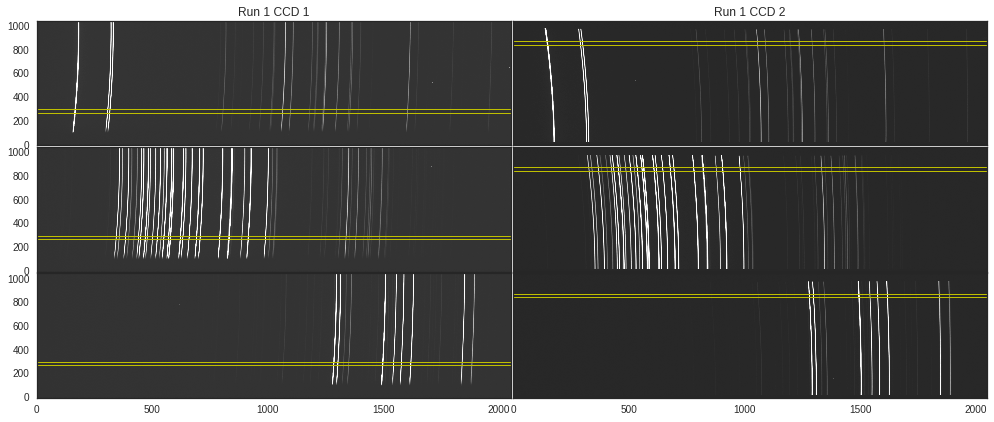

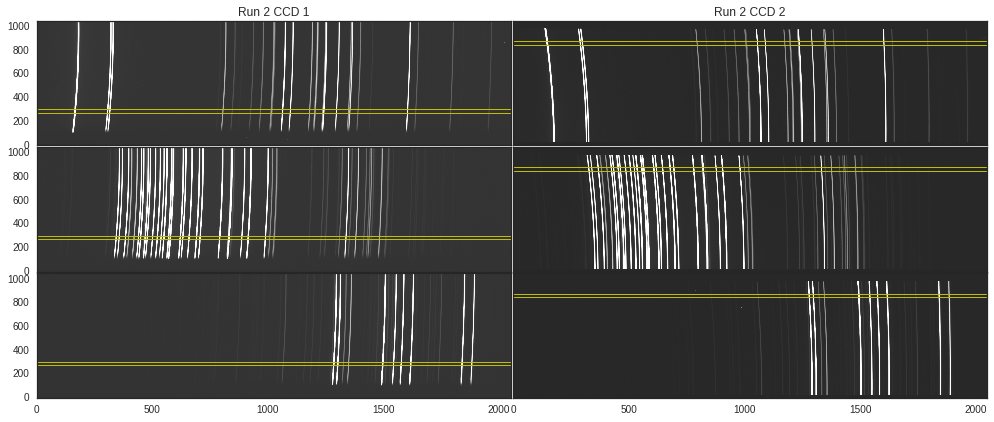

In [30]:
imargs = dict(aspect='auto', origin='image', cmap=cm.gray, vmin=500, vmax=4000)
for irun,ar in enumerate(arcs):
    fig,axs = subplots(3,2,figsize=(14,6),sharex=True)
    for i in range(3):
        axs[i,0].imshow(ar.ccd1[:,:,i].T, **imargs)
        axs[i,1].imshow(ar.ccd2[:,:,i].T, **imargs)
        axs[i,0].axhspan(ymins[0],ymaxs[0], color='y', fill=False, lw=1)
        axs[i,1].axhspan(ymins[1],ymaxs[1], color='y', fill=False, lw=1)
    setp(axs[0,0], title='Run %i CCD 1'%(irun+1))
    setp(axs[0,1], title='Run %i CCD 2'%(irun+1))
    setp(axs[:,1], yticks=[])
    setp(axs, ylim=(0,ar.ccd1.shape[1]))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.005, hspace=0.015)

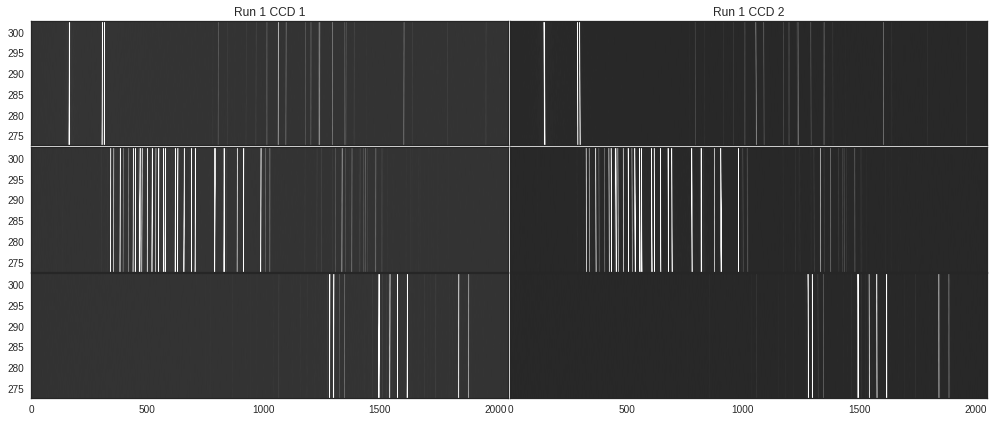

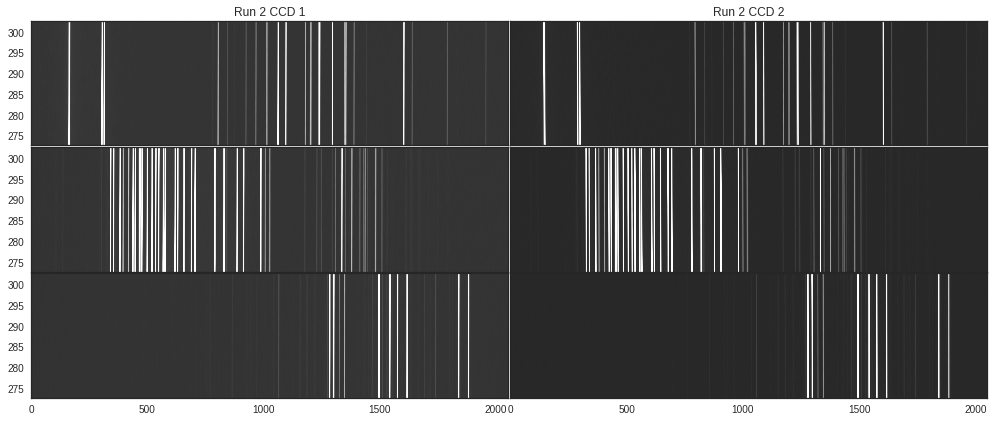

In [31]:
imargs = dict(aspect='auto', origin='image', cmap=cm.gray, vmin=500, vmax=4000)
for irun,ar in enumerate(arcs):
    fig,axs = subplots(3,2,figsize=(14,6),sharex=True)
    for i in range(3):
        axs[i,0].imshow(ar.ccd1[:,:,i].T, **imargs)
        axs[i,1].imshow(ar.ccd2[:,:,i].T, **imargs)
        axs[i,0].set_ylim(ymins[0],ymaxs[0])
        axs[i,1].set_ylim(ymins[1],ymaxs[1])
    setp(axs[0,0], title='Run %i CCD 1'%(irun+1))
    setp(axs[0,1], title='Run %i CCD 2'%(irun+1))
    setp(axs[:,1], yticks=[])
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.005, hspace=0.015)

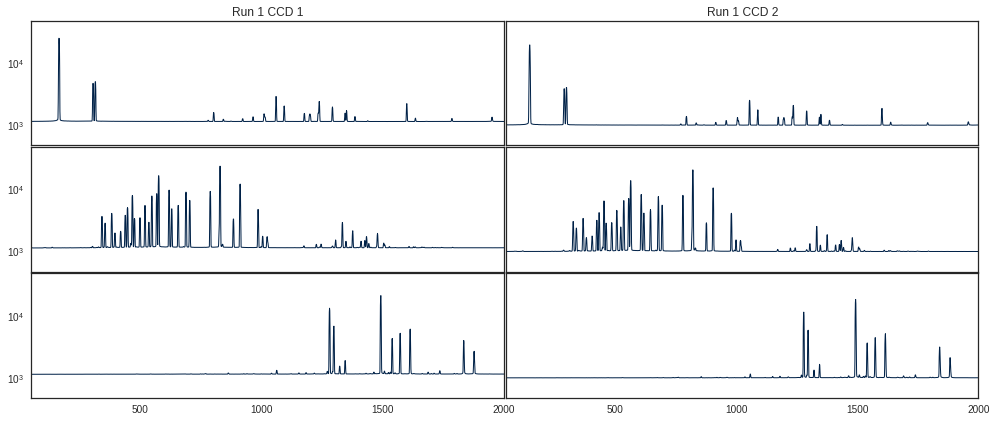

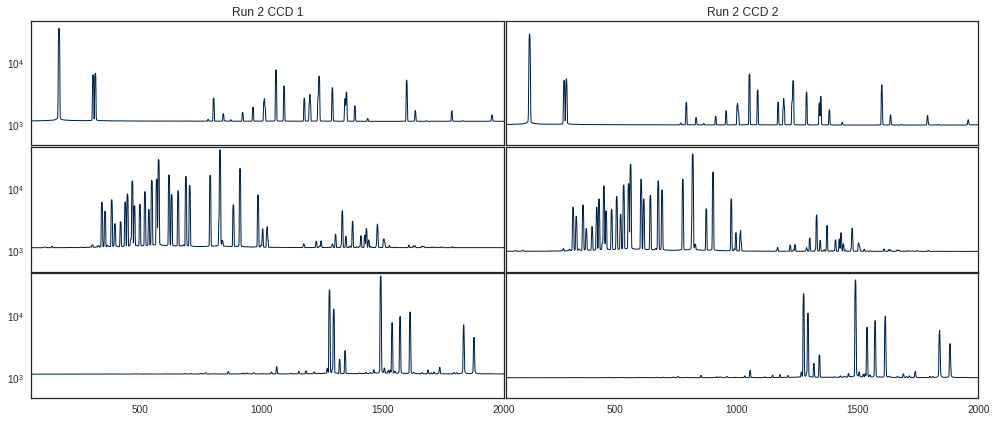

In [33]:
for irun,ar in enumerate(arcs):
    fig,axs = subplots(3,2,figsize=(14,6),sharex=True, sharey=True)
    for i in range(3):
        axs[i,0].semilogy(ar.ccd1[:,sl1,i].mean(1), lw=1)
        axs[i,1].semilogy(ar.ccd2[:,sl2,i].mean(1), lw=1)
    setp(axs[0,0], title='Run %i CCD 1'%(irun+1))
    setp(axs[0,1], title='Run %i CCD 2'%(irun+1))
    setp(axs, xlim=(50,2000), ylim=(500,51000))
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.005, hspace=0.015)

## Spectral line fitting

In [311]:
%run src/core.py

def subtract_median(a):
    return a-median(a)

class CCDFitter(object):
    def __init__(self, arc, sl, night):
        self.spectrum_hgar = subtract_median(arc[:,sl,0].mean(1))
        self.spectrum_ne   = subtract_median(arc[:,sl,1].mean(1))
        self.spectrum_xe   = subtract_median(arc[:,sl,2].mean(1))
        
        net = 500 if night == 1 else 1400
        
        cs_xe   = CalibrationSpectrum('XeI',  self.spectrum_xe,   lines_xe,   
                                      line_threshold=500.)
        cs_hgar = CalibrationSpectrum('HgAr', self.spectrum_hgar, lines_hgar,
                                      line_threshold=800., mask_ranges=[s_[1500:]])
        cs_ne   = CalibrationSpectrum('NeI', self.spectrum_ne,   lines_ne[:25], 
                                      line_threshold=net, mask_ranges=[s_[990:]]) 
        
        self.wlf = WLFitter([cs_xe, cs_hgar, cs_ne])
        
    def fit(self, offset=0):
        self.wlf.fit(offset=offset)

## Run 1

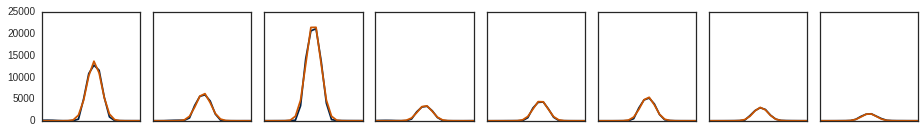

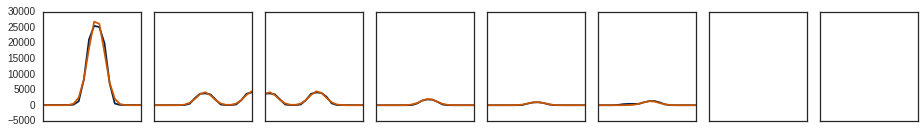

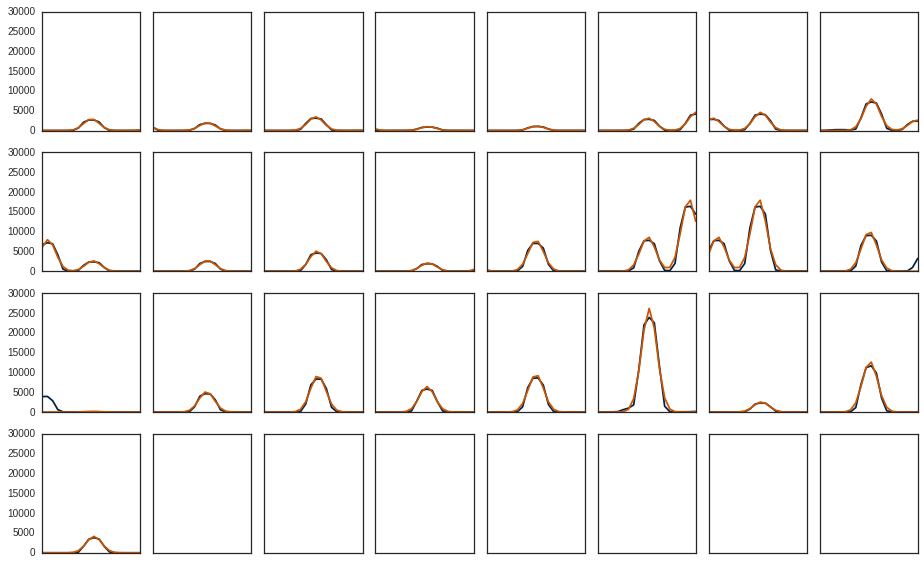

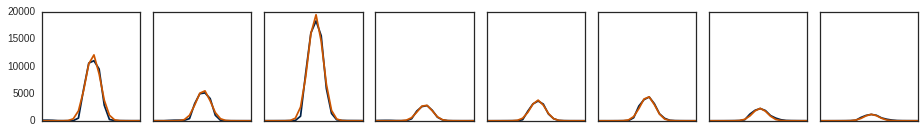

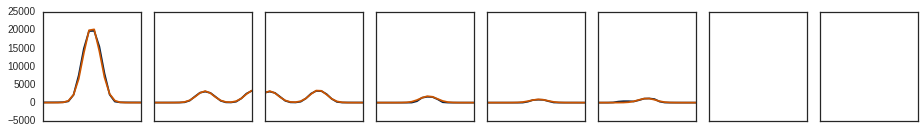

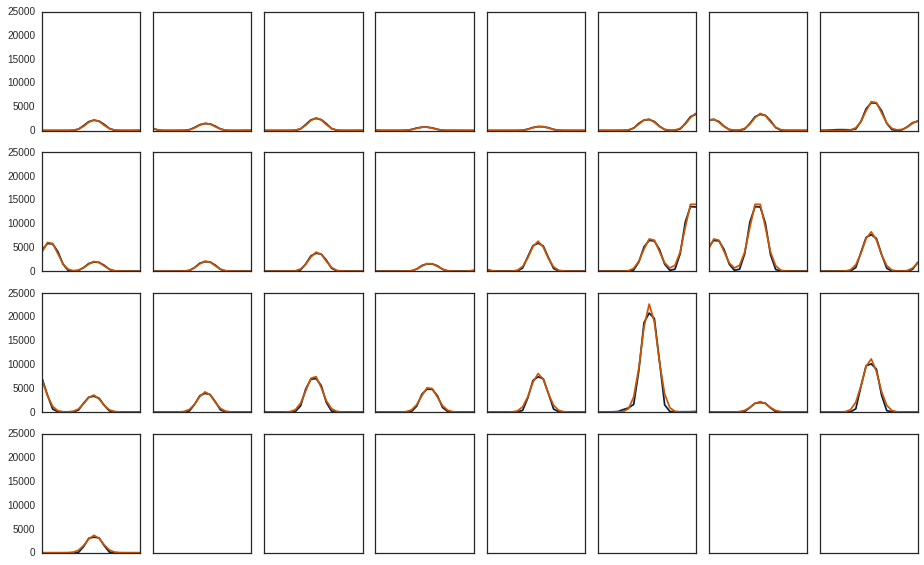

In [312]:
n1ccd1f = CCDFitter(arcs1.ccd1, sl1, night=1)
n1ccd2f = CCDFitter(arcs1.ccd2, sl2, night=1)

n1ccd1f.fit()
n1ccd2f.fit()

[s.plot() for s in n1ccd1f.wlf.spectra];
[s.plot() for s in n1ccd2f.wlf.spectra];

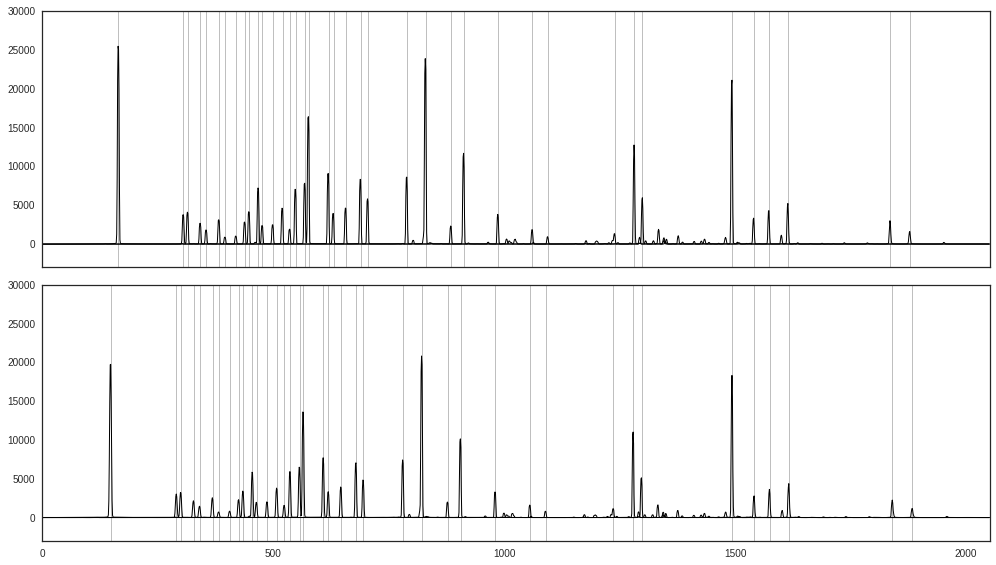

In [315]:
fig,ax = subplots(2,1,figsize=(14,8), sharex=True)
for iax, ccd in enumerate([n1ccd1f,n1ccd2f]):
    [ax[iax].axvline(l, c='k', alpha=0.25, ymax=1, lw=1) for l in ccd.wlf.wl_to_pixel(ccd.wlf.lines)]
    [ax[iax].plot(s.spectrum, c='k', lw=1) for s in ccd.wlf.spectra]
setp(ax, xlim=(0, ccd.wlf.spectra[0].spectrum.size), ylim=(-3e3,3e4))
fig.tight_layout()

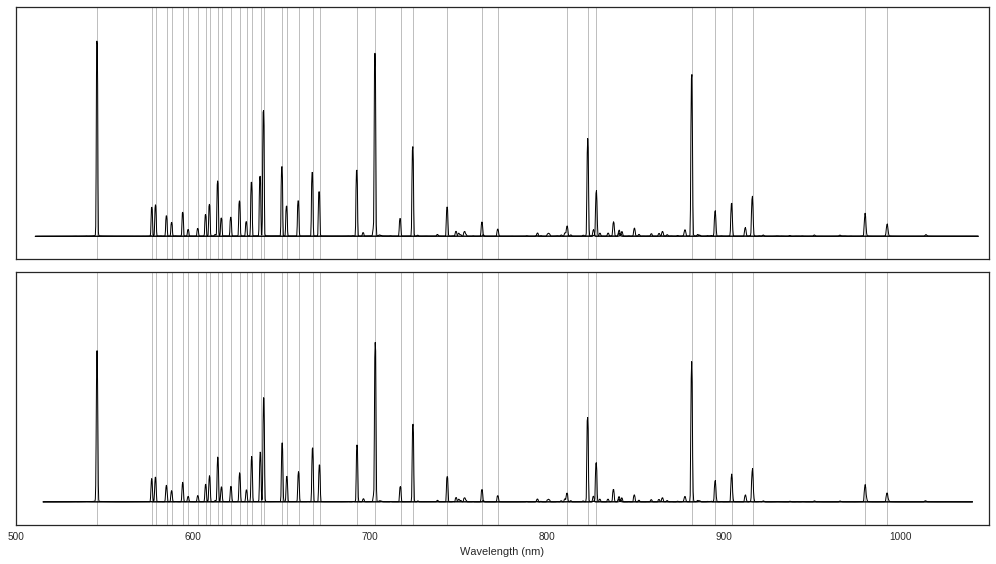

In [314]:
fig,ax = subplots(2,1,figsize=(14,8), sharex=True)
for iax, ccd in enumerate([n1ccd1f,n1ccd2f]):
    x = ccd.wlf.pixel_to_wl(arange(ccd.wlf.spectra[0].spectrum.size))
    [ax[iax].axvline(l, c='k', alpha=0.25, ymax=1, lw=1) for l in ccd.wlf.lines]
    [ax[iax].plot(x, s.spectrum, c='k', lw=1) for s in ccd.wlf.spectra]
setp(ax[1], xlim=(500, 1050),  xlabel='Wavelength (nm)')
setp(ax, yticks=[], ylim=(-3e3,3e4))
fig.tight_layout()

## Run 2

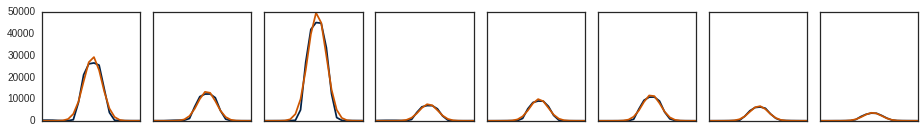

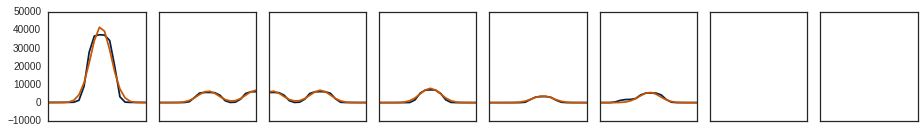

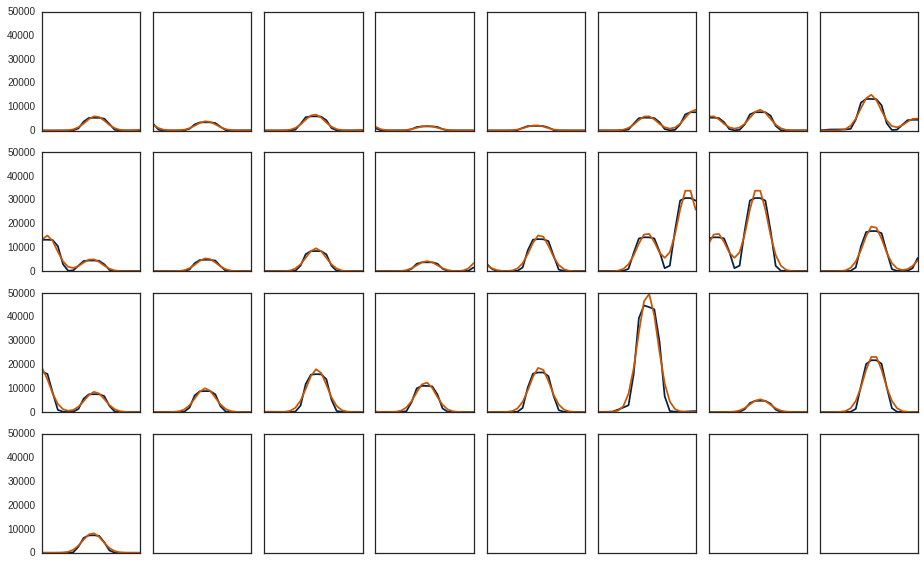

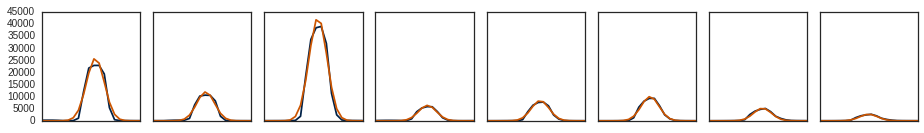

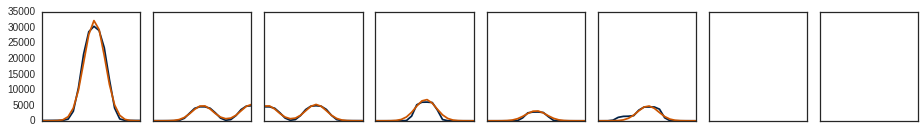

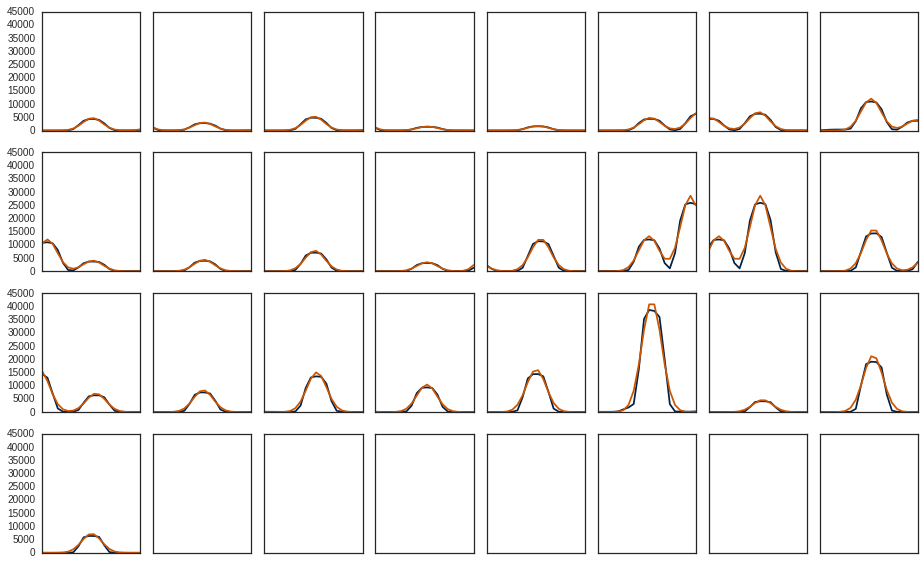

In [316]:
n2ccd1f = CCDFitter(arcs2.ccd1, sl1, night=2)
n2ccd2f = CCDFitter(arcs2.ccd2, sl2, night=2)

n2ccd1f.fit()
n2ccd2f.fit()

[s.plot() for s in n2ccd1f.wlf.spectra];
[s.plot() for s in n2ccd2f.wlf.spectra];

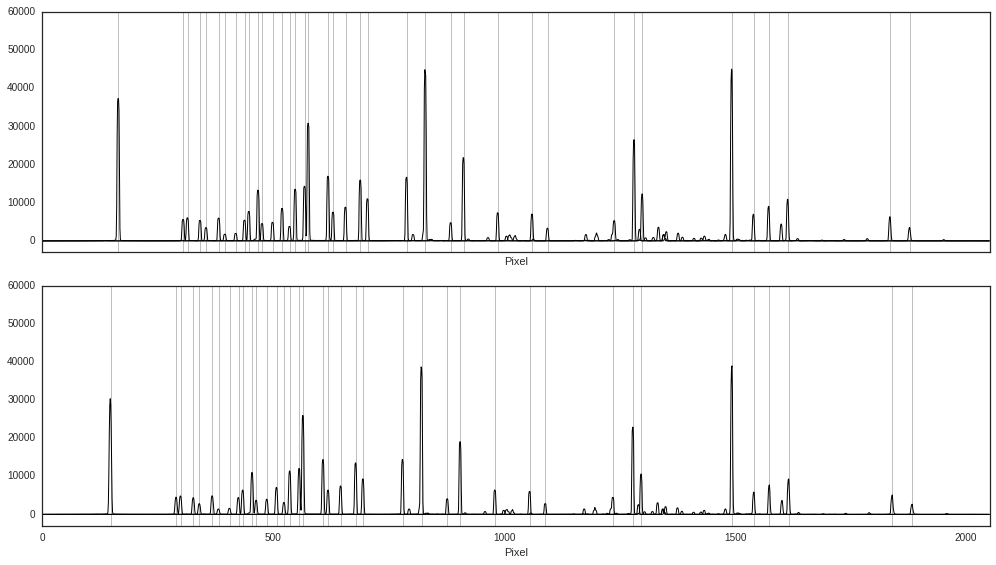

In [317]:
fig,ax = subplots(2,1,figsize=(14,8), sharex=True)
for iax, ccd in enumerate([n2ccd1f,n2ccd2f]):
    [ax[iax].axvline(l, c='k', alpha=0.25, ymax=1, lw=1) for l in ccd.wlf.wl_to_pixel(ccd.wlf.lines)]
    [ax[iax].plot(s.spectrum, c='k', lw=1) for s in ccd.wlf.spectra]
setp(ax, xlim=(0, ccd.wlf.spectra[0].spectrum.size), ylim=(-3e3,6e4), xlabel='Pixel')
fig.tight_layout()

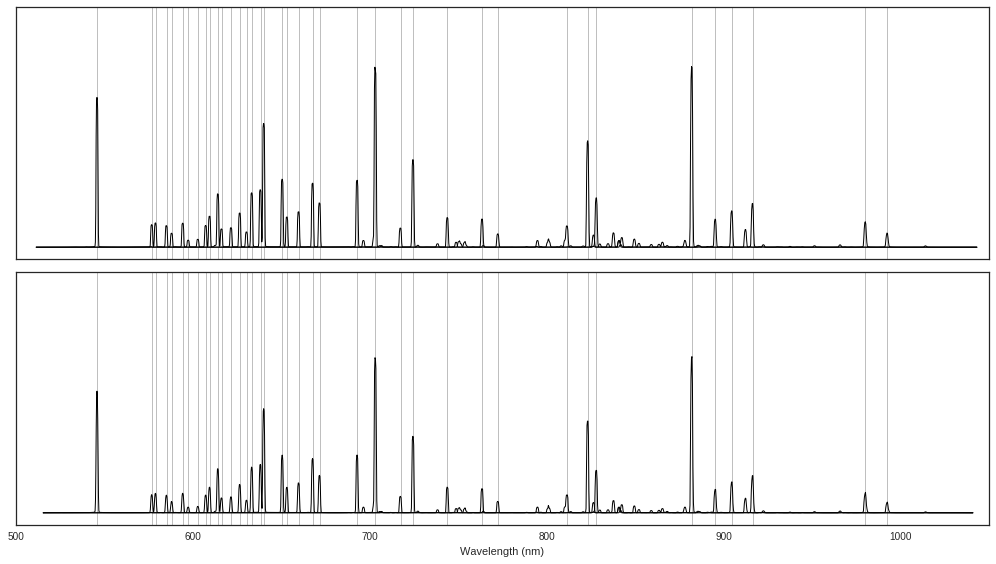

In [318]:
fig,ax = subplots(2,1,figsize=(14,8), sharex=True)
for iax, ccd in enumerate([n2ccd1f,n2ccd2f]):
    x = ccd.wlf.pixel_to_wl(arange(ccd.wlf.spectra[0].spectrum.size))
    [ax[iax].axvline(l, c='k', alpha=0.25, ymax=1, lw=1) for l in ccd.wlf.lines]
    [ax[iax].plot(x, s.spectrum, c='k', lw=1) for s in ccd.wlf.spectra]
setp(ax[1], xlim=(500, 1050),  xlabel='Wavelength (nm)')
setp(ax, yticks=[], ylim=(-3e3,6e4))
fig.tight_layout()

In [319]:
with open('results/wl_calibration.pkl', 'w') as f:
    dump(dict(n1ccd1=n1ccd1f.wlf.solution,
              n1ccd2=n1ccd2f.wlf.solution,
              n2ccd1=n2ccd1f.wlf.solution,
              n2ccd2=n2ccd2f.wlf.solution), f)

---

<center> &copy; 2016 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>